In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Compare greedy vs epsilon-greedy for 10-arm testbed

In [5]:
# create a bandit with n arms to compare greedy and epsilon-greedy
class Bandit():
    def __init__(self, n = 10, epsilon = 0, q0 = 0, alpha = 0.1):
        """
        n: number of arms
        epsilon: probability of selecting a random action
        q0: initial value for the estimated value of each action
        alpha: step size for the EWMA update method
        """
        self.n = n
        self.q = np.random.normal(0,1,n) # true values of the n arms, initailized with a normal distribution
        self.best_action = np.argmax(self.q) # the true best action to take
        self.action_count = np.ones(n) # number of times each action was taken, start from 1 to avoid division by zero
        self.action_value = np.zeros(n) + q0 # estimated value of each action
        self.epsilon = epsilon
        self.alpha = alpha # step size for the ewma update method

    # select an action using epsilon-greedy with UCB
    def select_action_ucb(self, step, c = 2):
        """
        epsilon: probability of selecting a random action
        step: the current step
        c: the exploration parameter
        """
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.n) # explore
        else:
            # step should start from 1
            ucb = self.action_value + c * np.sqrt(np.log(step) / self.action_count)
            return np.argmax(ucb)

    # select an action using epsilon-greedy
    def select_action_epsilon_greedy(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.n)
        else:
            return np.argmax(self.action_value)

    # update the estimated value of the selected action using the EWMA method
    def update_ewma(self, action, reward):
        """
        update action value using the EWMA method
        action: the action that was selected
        reward: the reward that was received
        """
        self.action_count[action] += 1
        self.action_value[action] += self.alpha * (reward - self.action_value[action])

    # update the estimated value using sample average
    def update(self, action, reward):
        """
        update action value using the sample average method
        action: the action that was selected
        reward: the reward that was received
        """
        self.action_count[action] += 1
        self.action_value[action] += (reward - self.action_value[action]) / self.action_count[action]

In [6]:
# simulate a bandit problem
def simulate_bandit(bandit, steps, ucb = False, ewma = False):
    """
    bandit: a Bandit instance to be simulated
    steps: the number of steps to simulate
    ucb: whether to use the ucb for action selection, if not then use epsilon-greedy
    ewma: whether to use the exponentially weighted moving average update rule
    """
    rewards = np.zeros(steps) # rewards at each step
    optimal_action = np.zeros(steps) # optimal action at each step
    for step in range(1,steps+1):
        if ucb:
            action = bandit.select_action_ucb(step)
        else:
            action = bandit.select_action_epsilon_greedy()
        if action == bandit.best_action:
            optimal_action[step-1] = 1
        reward = np.random.normal(bandit.q[action], 1) # reward is gaussian with mean: true reward, variance: 1
        rewards[step-1] = reward
        if ewma:
            bandit.update_ewma(action, reward)
        else:
            bandit.update(action, reward)

    return rewards, optimal_action


In [14]:
number_of_runs = 2000
number_of_steps = 1000
epsilons = [0, 0.01, 0.1]

# Initialize arrays to store average rewards and optimal actions for each epsilon
avg_rewards = np.zeros((len(epsilons), number_of_steps))
avg_optimal_actions = np.zeros((len(epsilons), number_of_steps))

# Loop over each epsilon
for i, epsilon in enumerate(epsilons):
    # Loop over each run
    for j in tqdm(range(number_of_runs), desc=f"Epsilon: {epsilon}", colour='green'):
        np.random.seed(j)
        # Initialize bandit with current epsilon
        if i == 0:
            bandit = Bandit(epsilon=epsilon, q0 = 5)
            rewards, optimal_actions = simulate_bandit(bandit, number_of_steps, ucb = False) # 1000 by 1
        else:
            bandit = Bandit(epsilon=epsilon)
            rewards, optimal_actions = simulate_bandit(bandit, number_of_steps, ucb = True)
        
        # Update average rewards and optimal actions
        avg_rewards[i] += (rewards - avg_rewards[i]) / (j + 1)
        avg_optimal_actions[i] += (optimal_actions - avg_optimal_actions[i]) / (j + 1)

Epsilon: 0.1: 100%|██████████| 2000/2000 [00:08<00:00, 240.64it/s]


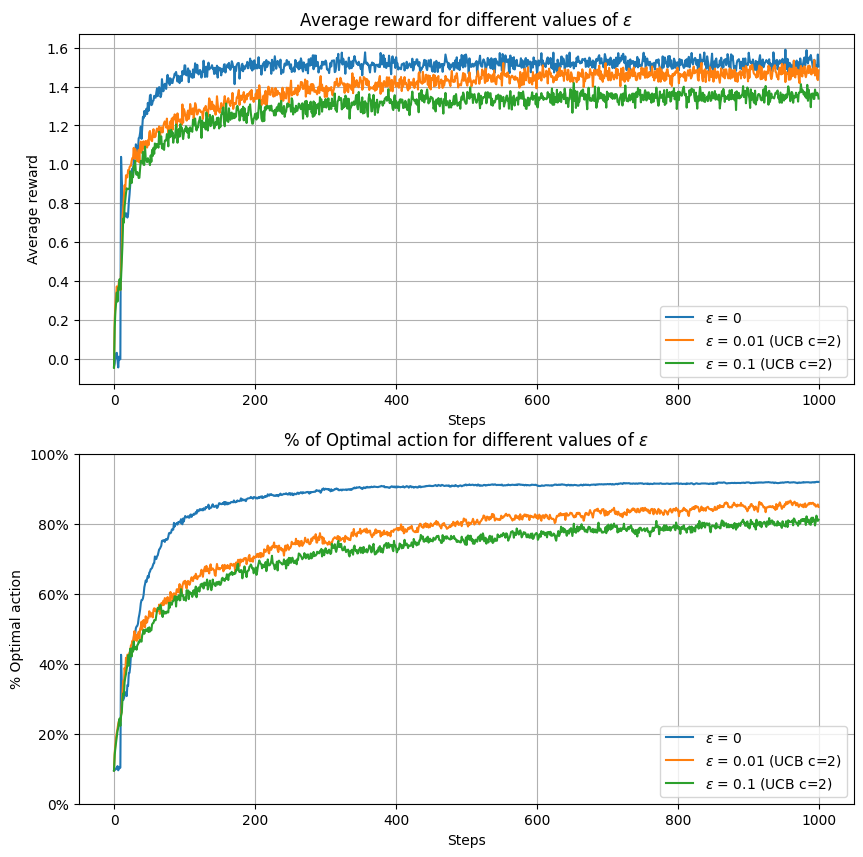

In [15]:
# Plot the results
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
for i, epsilon in enumerate(epsilons):
    plt.plot(avg_rewards[i], label=f'$\epsilon$ = {epsilon if i == 0 else str(epsilon) + " (UCB c=2)"}')
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.grid()
plt.legend()
plt.title('Average reward for different values of $\epsilon$')
plt.subplot(2, 1, 2)
for i, epsilon in enumerate(epsilons):
    plt.plot(avg_optimal_actions[i], label=f'$\epsilon$ = {epsilon if i == 0 else str(epsilon) + " (UCB c=2)"}')
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.grid()
plt.legend()
plt.title('% of Optimal action for different values of $\epsilon$')
plt.show()



## Rewrite with everything inside the class

In [27]:
# 
class Bandit():
    def __init__(self, n = 10, epsilon = 0, q0 = 0, alpha = 0.1):
        self.n = n
        self.q = np.random.normal(0,1,n)
        self.best_action = np.argmax(self.q)
        self.action_count = np.ones(n)
        self.action_value = np.zeros(n) + q0
        self.epsilon = epsilon
        self.alpha = alpha
        self.step = 1 # assume the first step is 1
        self.c = 2
    
    def select_action_epsilon_greedy(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.n)
        else:
            return np.argmax(self.action_value)
    
    def selection_action_ucb(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.n)
        else:
            ucb = self.action_value + self.c * np.sqrt(np.log(self.step) / self.action_count)
        return np.argmax(ucb)
    
    def update(self, action, reward):
        self.action_count[action] += 1
        self.action_value[action] += (reward - self.action_value[action]) / self.action_count[action]
        

    def update_ewma(self, action, reward):
        self.action_count[action] += 1
        self.action_value[action] += self.alpha * (reward - self.action_value[action])
        
    
    def simulate_bandit(self, steps, ucb = False, ewma = False):
        rewards = np.zeros(steps)
        optimal_action = np.zeros(steps)
        for step in range(1,steps+1):
            if ucb: # use UCB
                action = self.selection_action_ucb()
                reward = np.random.normal(self.q[action], 1)
            else: # use epsilon-greedy
                action = self.select_action_epsilon_greedy()
                reward = np.random.normal(self.q[action], 1)
            if ewma:
                self.update_ewma(action, reward)
            else:
                self.update(action, reward)
            if action == self.best_action:
                optimal_action[step-1] = 1
            rewards[step-1] = reward
            self.step += 1
        return rewards, optimal_action


In [35]:
# simulate the bandit problem
number_of_runs = 2000
number_of_steps = 1000
epsilons = [0, 0.01, 0.1]
# Initialize arrays to store average rewards and optimal actions for each epsilon
avg_rewards = np.zeros((len(epsilons), number_of_steps))
avg_optimal_actions = np.zeros((len(epsilons), number_of_steps))
# Loop over each epsilon
for i, epsilon in enumerate(epsilons):
    # Loop over each run
    for j in tqdm(range(number_of_runs), desc=f"Epsilon: {epsilon}", colour='green'):
        np.random.seed(j)
        # Initialize bandit with current epsilon
        if i == 0:
            bandit = Bandit(epsilon=epsilon, q0 = 5)
            rewards, optimal_actions = bandit.simulate_bandit(number_of_steps, ucb = False)
        else:
            bandit = Bandit(epsilon=epsilon)
            rewards, optimal_actions = bandit.simulate_bandit(number_of_steps, ucb = True)
        # Update average rewards and optimal actions
        avg_rewards[i] += (rewards - avg_rewards[i]) / (j + 1)
        avg_optimal_actions[i] += (optimal_actions - avg_optimal_actions[i]) / (j + 1)

Epsilon: 0.1: 100%|██████████| 2000/2000 [00:08<00:00, 235.40it/s]


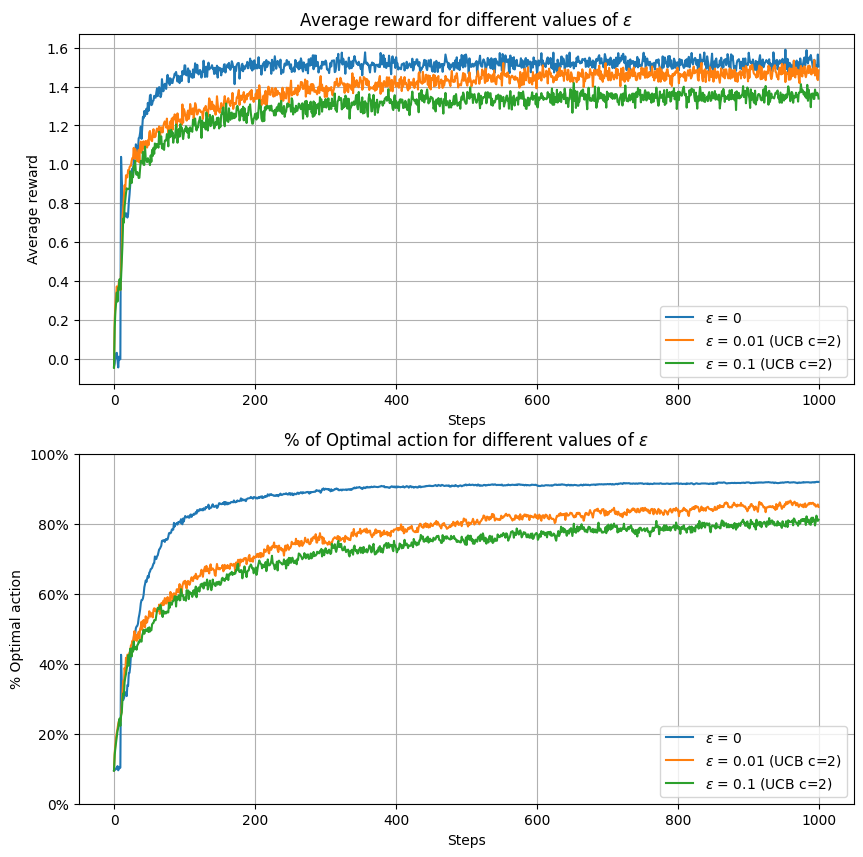

In [37]:
# Plot the results
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
for i, epsilon in enumerate(epsilons):
    plt.plot(avg_rewards[i], label=f'$\epsilon$ = {epsilon if i == 0 else str(epsilon) + " (UCB c=2)"}')
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.grid()
plt.legend()
plt.title('Average reward for different values of $\epsilon$')
plt.subplot(2, 1, 2)
for i, epsilon in enumerate(epsilons):
    plt.plot(avg_optimal_actions[i], label=f'$\epsilon$ = {epsilon if i == 0 else str(epsilon) + " (UCB c=2)"}')
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.grid()
plt.legend()
plt.title('% of Optimal action for different values of $\epsilon$')
plt.show()



## Compare sample average vs EWMA for non-stationary MAB (draft)

In [381]:
# non-stationary bandit
class Non_Stationary_Bandit(Bandit):
    def __init__(self, n = 10, epsilon = 0, q0 = 0, alpha = 0.1, sigma = 0.01):
        super().__init__(n, epsilon, q0, alpha)
        self.sigma = sigma # standard deviation of the normal distribution for the random walk
        self.q = np.zeros(n) # initial values of the n arms
        self.action_value = self.q + q0
        self.best_action = np.argmax(self.q) # the true best action to take
        self.preferences = np.zeros(n) # preference for each action, only used in the gradient bandit algorithm
        self.average_reward = 0  # Baseline reward
        self.step = 0  # To keep track of the number of steps

    # update the true values of the actions
    def update_q(self):
        self.q += np.random.normal(0, self.sigma, self.n) # each step add random walk
        self.best_action = np.argmax(self.q)
    
    def select_action_gradient_bandit(self):
        """Select action based on the softmax distribution of preferences."""
        exp_preferences = np.exp(self.preferences - np.max(self.preferences))  # Numerical stability trick
        prob = exp_preferences / np.sum(exp_preferences)
        action = np.random.choice(self.n, p=prob)
        return action

    def update_preferences(self, action, reward):
        """Update preferences using the gradient bandit algorithm."""
        exp_preferences = np.exp(self.preferences - np.max(self.preferences))  # Numerical stability trick
        prob = exp_preferences / np.sum(exp_preferences)

        self.average_reward = ((self.step * self.average_reward) + reward) / (self.step + 1)  # Update baseline reward

        for a in range(self.n):
            if a == action:
                self.preferences[a] += self.alpha * (reward - self.average_reward) * (1 - prob[a])
            else:
                self.preferences[a] -= self.alpha * (reward - self.average_reward) * prob[a]

        self.step += 1 # Update step

# simulate a non-stationary bandit problem
def simulate_non_stationary_bandit(bandit, steps, gradient = False, ewma = False):
    """
    bandit: a Non_Stationary_Bandit instance to be simulated
    steps: the number of steps to simulate
    gradient: whether to use the gradient bandit algorithm to select action, if not then use naive epsilon-greedy
    ewma: whether to use the exponentially weighted moving average update rule
    """
    rewards = np.zeros(steps) # rewards at each step
    optimal_action = np.zeros(steps) # optimal action at each step
    for step in range(1,steps+1):
        # select action
        if gradient: # gradient bandit algorithm
            action = bandit.select_action_gradient_bandit()
            reward = np.random.normal(bandit.q[action], 1)
            bandit.update_preferences(action, reward) # update preferences
        else: # epsilon greedy
            action = bandit.select_action_epsilon_greedy()
            reward = np.random.normal(bandit.q[action], 1)
            # update action value
            if ewma:
                bandit.update_ewma(action, reward)
            else:
                bandit.update(action, reward)
        if action == bandit.best_action: # update optimal action
            optimal_action[step-1] = 1
        rewards[step-1] = reward # update reward
        
        bandit.update_q() # update the true values of the actions every step

    return rewards, optimal_action

In [ ]:
# simulate the non-stationary bandit problem with j i
"""

number_of_runs = 20 # could be 2000
number_of_steps = 10000
labels = ['epsilon-greedy (sample average)', 'epsilon-greedy (EWMA)', 'gradient bandit algorithm']
avg_rewards = np.zeros((len(labels), number_of_steps))
avg_optimal_actions = np.zeros((len(labels), number_of_steps))

for j in tqdm(range(number_of_runs), desc="Runs", colour='green'):
    for i in range(len(labels)):
        if i == 0: # epsilon-greedy with sample average
            gradient = False
            ewma = False
        elif i == 1: # epsilon-greedy with ewma
            gradient = False
            ewma = True
        else: # gradient bandit algorithm
            gradient = True
            ewma = False

        bandit = Non_Stationary_Bandit(epsilon=0.1, alpha=0.1) # initialize bandit
        rewards, optimal_actions = simulate_non_stationary_bandit(bandit, number_of_steps, gradient, ewma)
        avg_rewards[i] += (rewards - avg_rewards[i]) / (j + 1) # update average rewards
        avg_optimal_actions[i] += (optimal_actions - avg_optimal_actions[i]) / (j + 1)
"""

Runs: 100%|██████████| 2000/2000 [08:35<00:00,  3.88it/s]


In [384]:
# original code
number_of_runs = 2000
number_of_steps = 10000
labels = ['epsilon-greedy (sample average)', 'epsilon-greedy (EWMA)', 'gradient bandit algorithm']
avg_rewards = np.zeros((len(labels), number_of_steps))
avg_optimal_actions = np.zeros((len(labels), number_of_steps))

for i in range(len(labels)):
    if i == 0: # epsilon-greedy with sample average
        gradient = False
        ewma = False
    elif i == 1: # epsilon-greedy with ewma
        gradient = False
        ewma = True
    else: # gradient bandit algorithm
        gradient = True
        ewma = False
    for j in tqdm(range(number_of_runs), desc=f"Bandit: {labels[i]}", colour='green'):
        bandit = Non_Stationary_Bandit(epsilon=0.1, alpha=0.1) # initialize bandit
        rewards, optimal_actions = simulate_non_stationary_bandit(bandit, number_of_steps, gradient, ewma)
        avg_rewards[i] += (rewards - avg_rewards[i]) / (j + 1) # update average rewards
        avg_optimal_actions[i] += (optimal_actions - avg_optimal_actions[i]) / (j + 1)


Bandit: gradient bandit algorithm: 100%|██████████| 2000/2000 [07:13<00:00,  4.61it/s]


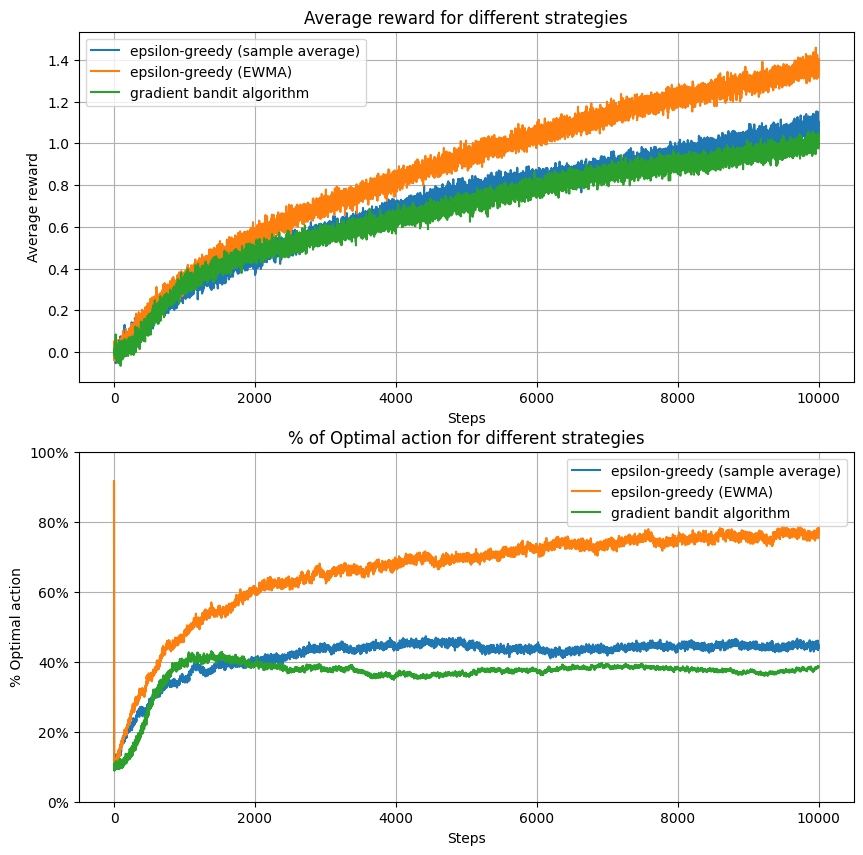

In [386]:
# Plot the results
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
for i, label in enumerate(labels):
    plt.plot(avg_rewards[i], label=label)
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.grid()
plt.legend()
plt.title('Average reward for different strategies')
plt.subplot(2, 1, 2)
for i, label in enumerate(labels):
    plt.plot(avg_optimal_actions[i], label=label)
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.grid()
plt.legend()
plt.title('% of Optimal action for different strategies')
plt.show()


## Non-Stationary Bandit
three algorithms are used
- Epsilon-greedy with updating action-value using sample average
- Epsilon-greedy with updating action-value using EWMA (eponentially weighted moving average )
- Gradient Bandit

In [38]:
class Non_Stationary_Bandit():
    def __init__(self, n = 10, epsilon = 0, q0 = 0, alpha = 0.1, sigma = 0.01):
        self.n = n
        self.q = np.zeros(n)
        self.best_action = np.argmax(self.q)
        self.action_count = np.ones(n)
        self.action_value = np.zeros(n) + q0
        self.epsilon = epsilon
        self.alpha = alpha
        self.sigma = sigma
        self.preferences = np.zeros(n)
        self.average_reward = 0
        self.step = 0
    
    def update_q(self):
        self.q += np.random.normal(0, self.sigma, self.n)
        self.best_action = np.argmax(self.q)
    
    def select_action_gradient_bandit(self):
        exp_preferences = np.exp(self.preferences - np.max(self.preferences))
        prob = exp_preferences / np.sum(exp_preferences)
        action = np.random.choice(self.n, p=prob)
        return action

    def update_preferences(self, action, reward):
        exp_preferences = np.exp(self.preferences - np.max(self.preferences))
        prob = exp_preferences / np.sum(exp_preferences)

        self.average_reward = ((self.step * self.average_reward) + reward) / (self.step + 1)

        for a in range(self.n):
            if a == action:
                self.preferences[a] += self.alpha * (reward - self.average_reward) * (1 - prob[a])
            else:
                self.preferences[a] -= self.alpha * (reward - self.average_reward) * prob[a]
    
    def select_action_epsilon_greedy(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.n)
        else:
            return np.argmax(self.action_value)
    
    def update(self, action, reward):
        self.action_count[action] += 1
        self.action_value[action] += (reward - self.action_value[action]) / self.action_count[action]
    
    def update_ewma(self, action, reward):
        self.action_count[action] += 1
        self.action_value[action] += self.alpha * (reward - self.action_value[action])
    
    def simulate_non_stationary_bandit(self, steps, gradient = False, ewma = False):
        rewards = np.zeros(steps)
        optimal_action = np.zeros(steps)
        for step in range(1,steps+1):
            if gradient:
                action = self.select_action_gradient_bandit()
                reward = np.random.normal(self.q[action], 1)
                self.update_preferences(action, reward)
            else:
                action = self.select_action_epsilon_greedy()
                reward = np.random.normal(self.q[action], 1)
                if ewma:
                    self.update_ewma(action, reward)
                else:
                    self.update(action, reward)
            if action == self.best_action:
                optimal_action[step-1] = 1
            rewards[step-1] = reward
            self.update_q()
            self.step += 1
        return rewards, optimal_action


In [41]:
# simulate with 3 strategies
number_of_runs = 2000
number_of_steps = 10000
labels = ['epsilon-greedy (sample average)', 'epsilon-greedy (EWMA)', 'gradient bandit algorithm']
avg_rewards = np.zeros((len(labels), number_of_steps))
avg_optimal_actions = np.zeros((len(labels), number_of_steps))
for i in range(len(labels)):
    if i == 0: # epsilon-greedy with sample average
        gradient = False
        ewma = False
    elif i == 1: # epsilon-greedy with ewma
        gradient = False
        ewma = True
    else: # gradient bandit algorithm
        gradient = True
        ewma = False
    for j in tqdm(range(number_of_runs), desc=f"Bandit: {labels[i]}", colour='green'):
        np.random.seed(j) # set seed for reproducibility across runs
        bandit = Non_Stationary_Bandit(epsilon=0.1, alpha=0.1) # initialize bandit
        rewards, optimal_actions = bandit.simulate_non_stationary_bandit(number_of_steps, gradient, ewma)
        avg_rewards[i] += (rewards - avg_rewards[i]) / (j + 1) # update average rewards
        avg_optimal_actions[i] += (optimal_actions - avg_optimal_actions[i]) / (j + 1)



Bandit: gradient bandit algorithm: 100%|██████████| 2000/2000 [07:48<00:00,  4.27it/s] 


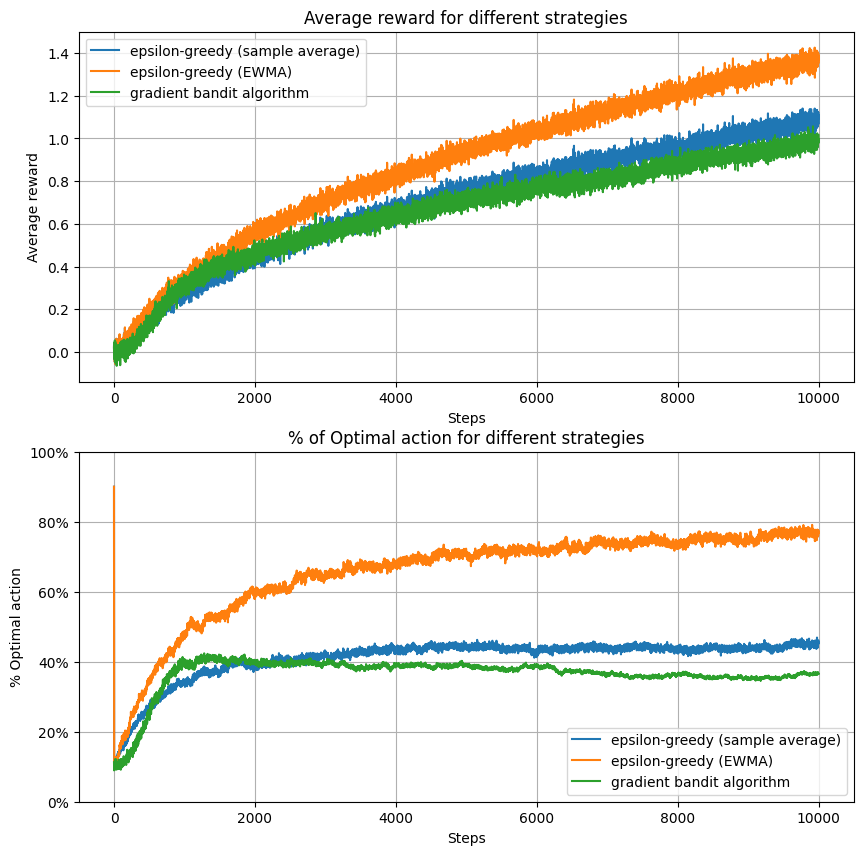

In [42]:
# Plot the results
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
for i, label in enumerate(labels):
    plt.plot(avg_rewards[i], label=label)
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.grid()
plt.legend()
plt.title('Average reward for different strategies')
plt.subplot(2, 1, 2)
for i, label in enumerate(labels):
    plt.plot(avg_optimal_actions[i], label=label)
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.grid()
plt.legend()
plt.title('% of Optimal action for different strategies')
plt.show()
